In [13]:
machine = 'mac'
machine = 'magny'

In [14]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

import datetime

%matplotlib inline

In [15]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [16]:
maxr = s.galrad
maxr = 0.01 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [$(\x0crac{km}{s})^2]$')

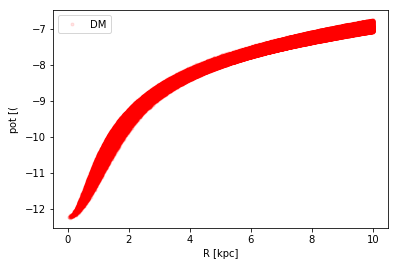

In [17]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]$')

In [18]:
print(np.min(vR_kms))

0.24112


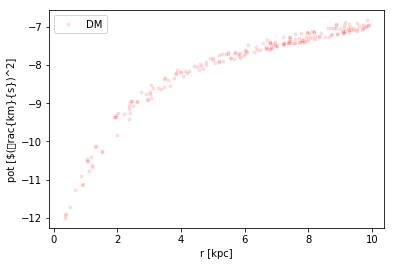

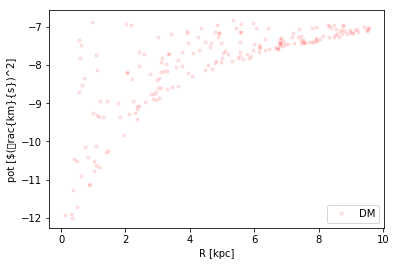

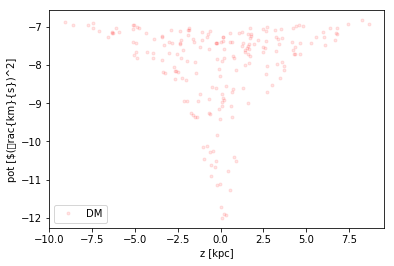

In [19]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)),201))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]

R_kpc_data,z_kpc_data,pot_kms2_data = rand_R_dm, rand_z_dm, rand_pot_dm

plt.plot(rand_r_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()
plt.plot(rand_R_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()
plt.plot(rand_z_dm, rand_pot_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('z [kpc]')
plt.ylabel('pot [$(\frac{km}{s})^2]')
plt.show()


In [20]:
#_____reference values for galpy_____
_REFR0_kpc = 4.

In [21]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,n_MND,n_NFWH): #a_HB_kpc,,n_HB
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.)  \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.): #  or (n_HB <= 0.), or (n_HB >= 1.) or (a_HB_kpc <= 0.)
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH - 1.) > 1e-7: #  + n_HB 
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    #a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    #bulge = HernquistPotential(
                #a=a_HB,
                #normalize=n_HB)
    #return [disk,halo,bulge]
    return [disk,halo]

Scipy differential_evolution
----


In [22]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    '''
    INPUT: x: parameters to be fitted
               x[0]: v0 [km/s]
               x[1], x[2]: scale lengths of Miyamoto Nagai disk [kpc]
               x[3], x[4]: scale length of MFW and Hernquist halo and bulge potentials [kpc]
               x[5], x[6]: normalization of MND and NFWH (including normalization of HB by subtracting them from 1)
           args: data
               args[0], args[1]: grid of R and z in kpc
               args[2]: potential in (km/s)**2
    OUTPUT: err: sum of relative error squares
    '''
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    #a_HB_kpc   = x[4]
    n_MND      = x[4]
    n_NFWH     = 1 - n_MND#x[6]
    #n_HB       = 1.-n_NFWH-n_MND
    
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,n_MND,n_NFWH) #a_HB_kpc, ,n_HB
        #print('Setup potential works.')
    except Exception as e:
        #uncomment for debugging:
        #print(e.message)
        #print(x)
        return np.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(((pot_kms2_data - pot_kms2_model) / pot_kms2_model)**2)
    #print(err)
    return err

In [23]:
lower_floor = 1e-3
bounds = ((lower_floor,400.), #vcirc
          (lower_floor,15.), #a_MND
          (lower_floor,10.), #b_MND
          (lower_floor,50.), #a_NFWH
          (0.,1.), #n_MND
          (0.,1.)) #n_NFWH

#(lower_floor,10.), #a_HB

#fitting:
res = opt.differential_evolution(
            rel_pot_error_scipydifferentialevolution,
            bounds=bounds,
            args=(R_kpc_data,z_kpc_data,pot_kms2_data),
            strategy='best1bin',
            maxiter=10000,tol=0.001,atol=1e-7,
            disp=False
            )

print(res)
print("best fit:")
print("v0_kms    ", res.x[0])
print("a_MND_kpc ", res.x[1])
print("b_MND_kpc ", res.x[2])
print("a_NFWH_kpc", res.x[3])
#print("a_HB_kpc  ", res.x[4])
print("n_MND     ", res.x[4])
print("n_NFWH    ", 1.-res.x[4])
#print("n_HB      ", 1.-res.x[5]-res.x[6])


     fun: 0.21341718340794646
 message: 'Optimization terminated successfully.'
    nfev: 13431
     nit: 148
 success: True
       x: array([  1.30133555e+00,   1.49946640e+01,   6.14823084e-03,
         6.09713490e+00,   4.67151399e-02,   4.34306982e-01])
best fit:
v0_kms     1.30133555301
a_MND_kpc  14.9946639845
b_MND_kpc  0.00614823084215
a_NFWH_kpc 6.09713489627
n_MND      0.0467151398906
n_NFWH     0.953284860109


if not working try to fit without HB

emcee fitting
----

In [24]:
#_____function for MCMC, sum of error squares_____
def lnprob_MCMC(x,*args):
    
    #read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    #a_HB_kpc   = x[4]
    n_MND      = x[4]
    n_NFWH     = 1. - n_MND
    #n_HB       = 1.-n_NFWH-n_MND
    
    #check if imput parameters are physical:
    if v0_kms <= 0: return -np.inf
    #(Note: all other parameters are checked during setting up the galpy potential.)
        
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    
    #setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,n_MND,n_NFWH) #,a_HB_kpc, ,n_HB
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return -np.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data/_REFR0_kpc,
                                   z_kpc_data/_REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(-0.5*(pot_kms2_data-pot_kms2_model)**2)
    return err

In [25]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 6, 50, 1000

#initial values for fit:
v0_kms_init     = 150.
a_MND_kpc_init  = 6.
b_MND_kpc_init  = 1.
a_NFWH_kpc_init = 10.
#a_HB_kpc_init   = 2.
n_MND_init      = 0.2
n_NFWH_init     = 0.6
initial_guess = np.array([v0_kms_init,a_MND_kpc_init,b_MND_kpc_init,a_NFWH_kpc_init,
                             n_MND_init,n_NFWH_init]) #a_HB_kpc_init,
initial_guess_width = np.fabs(0.2*initial_guess)
p0 = np.array([np.random.randn(ndim)*np.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])
#fiitting boundaries:
boundaries = np.array([[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,1.],[0.,1.]]) #[0.,np.inf],
for pp in range(ndim):
    p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + np.random.uniform() * 0.1
    p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - np.random.uniform() * 0.1

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 500
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

In [26]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = np.percentile(final_samples,[16.,50.,84.],axis=0)
median = np.median(final_samples,axis=0)
std = np.std(final_samples,axis=0)
print("true vs. best fit:")
print("v0_kms    ",median[0],"\t","+/-",std[0])
print("a_MND_kpc ",median[1],"\t","+/-",std[1])
print("b_MND_kpc ",median[2],"\t","+/-",std[2])
print("a_NFWH_kpc",median[3],"\t","+/-",std[3])
#print("a_HB_kpc  ",median[4],"\t","+/-",std[4])
print("n_MND     ",median[4],"\t","+/-",std[4])
print("n_NFWH    ",1. - median[4],"\t","+/-",std[4])
#print("n_HB      ",1.-median[5]-median[6])

true vs. best fit:
v0_kms     1.29744937391 	 +/- 0.114315907749
a_MND_kpc  0.830491598097 	 +/- 5.62945218339
b_MND_kpc  0.567666761688 	 +/- 1.35577178903
a_NFWH_kpc 18.7768935833 	 +/- 9.7774717431
n_MND      0.609097192408 	 +/- 0.20309365461
n_NFWH     0.390902807592 	 +/- 0.20309365461


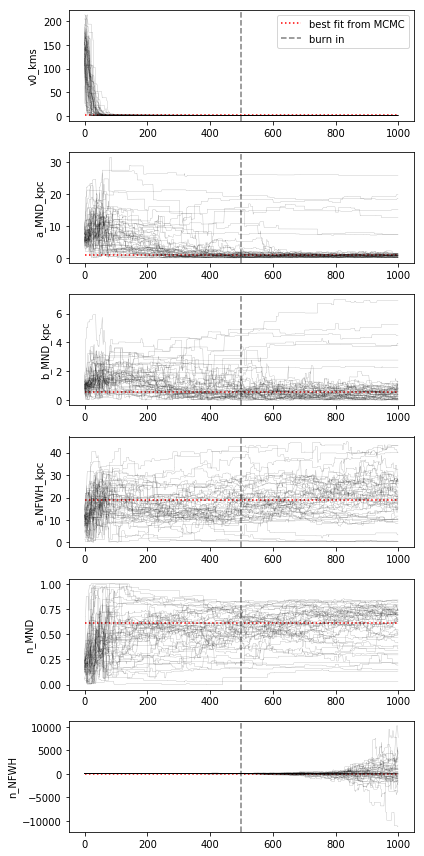

In [27]:
#plot progress
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","n_MND","n_NFWH"] #"a_HB_kpc",,"n_HB"
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(np.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = np.percentile(final_samples[:,ii],[50.])
    #ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()

In [28]:
#_____prepare MCMC_____
ndim, nwalkers, nstep = 6, 50, 1000

#initial values for fit:
initial_guess = median
initial_guess_width = 0.1*std
p0 = np.array([np.random.randn(ndim)*np.array(initial_guess_width)+initial_guess \
                                              for i in range(nwalkers)])

#_____run MCMC_____
sampler = emcee.EnsembleSampler(nwalkers,ndim,
                               lnprob_MCMC,
                               args=[R_kpc_data,z_kpc_data,pot_kms2_data])
sampler.run_mcmc(p0,nstep)

#result:
burnin = 700
final_samples = sampler.chain[:, burnin:, :].reshape((-1,ndim))
chain_samples = sampler.chain

/home/extmilan/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0

/home/extmilan/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))



In [29]:
#===== OUTPUT =====

#_____take precentiles_____
#perc = np.percentile(final_samples,[16.,50.,84.],axis=0)
median = np.median(final_samples,axis=0)
std = np.std(final_samples,axis=0)
print("true vs. best fit:")
print("v0_kms    ",median[0],"\t","+/-",std[0])
print("a_MND_kpc ",median[1],"\t","+/-",std[1])
print("b_MND_kpc ",median[2],"\t","+/-",std[2])
print("a_NFWH_kpc",median[3],"\t","+/-",std[3])
#print("a_HB_kpc  ",median[4],"\t","+/-",std[4])
print("n_MND     ",median[4],"\t","+/-",std[4])
print("n_NFWH    ",1.-median[4],"\t","+/-",std[4])
#print("n_HB      ",1.-median[5]-median[6])

true vs. best fit:
v0_kms     1.29713972461 	 +/- 0.080432176868
a_MND_kpc  0.579296113066 	 +/- 0.570183785558
b_MND_kpc  0.521943401332 	 +/- 0.439263151819
a_NFWH_kpc 19.449880373 	 +/- 6.03726157482
n_MND      0.624204551113 	 +/- 0.109745807003
n_NFWH     0.375795448887 	 +/- 0.109745807003


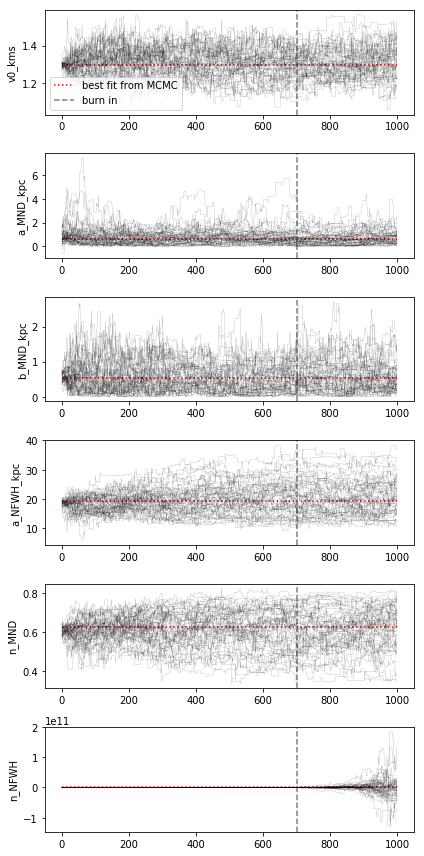

In [30]:
#plot progress
fig = plt.figure(figsize=(6,12))
ax_list = [fig.add_subplot(ndim,1,ii+1) for ii in range(ndim)]
for ii in range(ndim):
    ax = ax_list[ii]
    ax.set_ylabel(labels[ii])
    for jj in range(nwalkers):
        ax.plot(np.arange(nstep),chain_samples[jj,:,ii],color='k',alpha=0.5,linewidth=0.2)    
for ii in range(ndim):
    ax = ax_list[ii]
    perc = np.percentile(final_samples[:,ii],[50.])
    #ax.hlines(true_values[ii],0.,nstep,color='green',linestyles=['solid'],label='true value')
    ax.hlines(perc,0.,nstep,color='red',linestyles=['dotted'],label='best fit from MCMC')
    ylim = ax.get_ylim()
    ax.vlines([burnin],ylim[0],ylim[1],color='grey',linestyle='dashed',label='burn in')
    ax.set_ylim(ylim)
    if ii == 0: ax.legend()
plt.tight_layout()
plt.show()